In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk, re, time
from nltk.corpus import stopwords

from bs4 import BeautifulSoup 

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

nltk.download('stopwords')
from time import time
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/ideis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv( "data/testData.tsv", header=0, delimiter="\t", quoting=3)

print("Train: %d, Test: %d\n"
      % (train["review"].size, test["review"].size))

Train: 25000, Test: 25000



In [3]:
def clean_text(text, remove_stopwords=True):
    '''Clean the text, with the option to remove stopwords'''
    text = BeautifulSoup(text).get_text()
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    return(text)

def extract_sentiment(s):
    s = re.sub(r"[^0-9]", " ", s)
    n = int(s.split()[1])
    if n <= 5:
        return 0
    else:
        return 1
train['review'] = train.apply(lambda x: clean_text(x['review']), axis=1)
test['review'] = test.apply(lambda x: clean_text(x['review']), axis=1)
test['sentiment'] = test.apply(lambda x: extract_sentiment(x['id']), axis=1)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 200  # Max length of review
max_features = 1000  # Number of words to consider as features
max_words = 1000  # Number of words to consider in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train["review"])
sequences = tokenizer.texts_to_sequences(train["review"])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(train["sentiment"])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 74216 unique tokens.
Shape of data tensor: (25000, 200)
Shape of label tensor: (25000,)


In [5]:
training_samples = 20000
validation_samples = 5000

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [10]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten

model = Sequential()
model.add(layers.Embedding(max_features, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           32000     
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 25604     
_________________________________________________________________
dropout_7 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_8 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total para

In [11]:
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val,y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 123us/step - loss: 0.6684 - acc: 0.5597 - val_loss: 0.5090 - val_acc: 0.7892
Epoch 2/10
20000/20000 [==============================] - 2s 106us/step - loss: 0.4571 - acc: 0.8020 - val_loss: 0.3613 - val_acc: 0.8458
Epoch 3/10
20000/20000 [==============================] - 2s 105us/step - loss: 0.3748 - acc: 0.8542 - val_loss: 0.3605 - val_acc: 0.8392
Epoch 4/10
20000/20000 [==============================] - 2s 109us/step - loss: 0.3126 - acc: 0.8901 - val_loss: 0.3860 - val_acc: 0.8362
Epoch 5/10
20000/20000 [==============================] - 2s 112us/step - loss: 0.2503 - acc: 0.9180 - val_loss: 0.4386 - val_acc: 0.8274
Epoch 6/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.2031 - acc: 0.9362 - val_loss: 0.5436 - val_acc: 0.8318
Epoch 7/10
20000/20000 [==============================] - 2s 113us/step - loss: 0.1726 - acc: 0.9471 - val_loss: 0.6292 - v

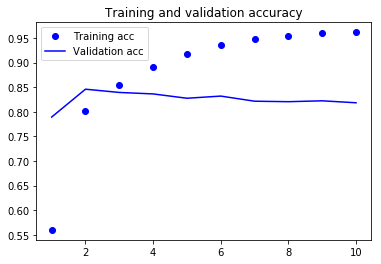

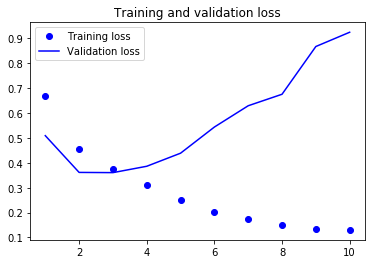

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('dense-acc.png')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('dense-loss.png')

plt.show()

In [13]:
sequences = tokenizer.texts_to_sequences(test["review"])
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(test["sentiment"])

scores = model.evaluate(x_test, y_test)
print("Accuracy:", scores[1])

25000/25000 [==============================] - 1s 39us/step
Accuracy: 0.8206


In [14]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict_proba(x_test)
print("ROC-AUC:",roc_auc_score(y_test, y_pred))

ROC-AUC: 0.89923936
